In [16]:
import os
import sys
import glob
from dataclasses import dataclass, make_dataclass
from collections import defaultdict
from functools import reduce, partial
from typing import Any

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import ete3
from ete3 import PhyloTree
from Bio import SeqIO

from pymutspec.annotation import iter_tree_edges


In [2]:
def custom_historgam(array, bins=[0.0, 0.05, 0.3, 0.5, 0.8, 1.0]):
    hei = np.histogram(array, bins=bins)[0]
    data = {q: x for q, x in zip(bins[1:], hei)}
    return data

In [3]:
data=[]
for name in ["human", "mus"]:
    for gene in ["nd1", "cytb"]:
        df = pd.read_csv(f"../data/exposure/{name}_{gene}/observed_mutations_iqtree.tsv", sep="\t")
        data.append([f"{name}_{gene}", pd.DataFrame, df])

        df.groupby(["RefNode", "AltNode"]).ProbaFull.apply(custom_historgam)\
            .reset_index()\
                .rename(columns={"level_2": "Bin", "ProbaFull": "Count"})\
                    .to_csv(f"../data/exposure/summary/proba_distributions/{name}_{gene}.csv", index=False)


muts = make_dataclass("mutations", data)

In [28]:
name = "mammals"

for gene in ["nd1", "cytb"]:
    df = pd.read_csv(f"../data/exposure/{name}_{gene}/proba/mutations.tsv", sep="\t")
    df.groupby(["RefNode", "AltNode"]).ProbaFull.apply(custom_historgam)\
        .reset_index()\
            .rename(columns={"level_2": "Bin", "ProbaFull": "Count"})\
                .to_csv(f"../data/exposure/summary/proba_distributions/{name}_{gene}.csv", index=False)


In [84]:
for name in ["human", "mus", "mammals"]:
    for gene in ["nd1", "cytb"]:
        tree = PhyloTree(f'../data/exposure/summary/proba_distributions/{name}_{gene}.nwk', format=1)
        df = pd.read_csv(f"../data/exposure/summary/proba_distributions/{name}_{gene}.csv")
        alt2root_dist = dict()
        ref2leaf_dist = dict()
        for ref_node, alt_node in iter_tree_edges(tree):
            alt2root_dist[alt_node.name] = alt_node.dist
            ref2leaf_dist[ref_node.name] = ref_node.get_closest_leaf()[1]
        
        df["LeafDist"] = df.RefNode.map(ref2leaf_dist)
        df["RootDist"] = df.AltNode.map(alt2root_dist)
        df["dummy"] = df.Count.apply(lambda x: [1 for _ in range(x)])
        
        ax = sns.displot(
            data=df.explode("dummy", True),
            x="RootDist", hue="Bin", 
            kind="kde", height=4, aspect=2,
            multiple="fill", clip=(0, None),
            palette="ch:rot=-.25,hue=1,light=.75",
        )
        plt.title(f"{name}_{gene} distributions of mutations probability")
        plt.savefig(f"../data/exposure/summary/proba_distributions/figures/{name}_{gene}.png")
        plt.close()

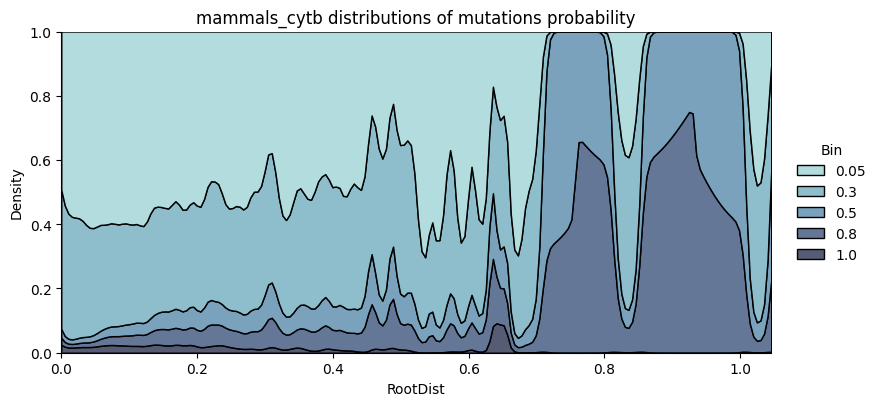

In [85]:
sns.displot(
    data=df.explode("dummy", True),
    x="RootDist", hue="Bin", 
    kind="kde", height=4, aspect=2,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)
plt.title(f"{name}_{gene} distributions of mutations probability")
plt.show()

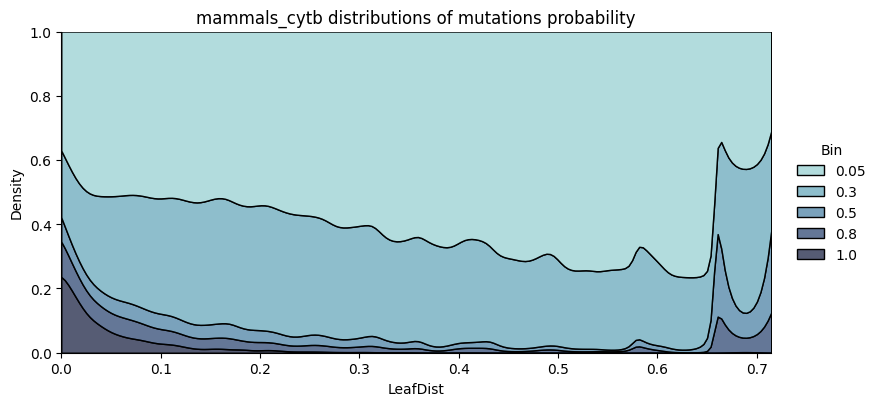

In [86]:
sns.displot(
    data=df.explode("dummy", True),
    x="LeafDist", hue="Bin", 
    kind="kde", height=4, aspect=2,
    multiple="fill", clip=(0, None),
    palette="ch:rot=-.25,hue=1,light=.75",
)
plt.title(f"{name}_{gene} distributions of mutations probability")
plt.show()